<a href="https://colab.research.google.com/github/reky-5093/Banknote_DL/blob/main/Banknote_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Banknote Authentication Dataset**

---



문제 정의
진짜 지폐를 평가하는 4가지 요소가 있다. 이 데이터 셋에는 가짜 지폐와 진짜 지폐가 있으며, 학습을 통해서, 진짜 지폐인지 가짜지폐인지를 구분하는 2-class classification이다.

---


출처[https://archive.ics.uci.edu/ml/datasets/banknote+authentication]

# **1. 데이터로드**

---



파일이 txt 파일이라서, 엑셀 데이터 셋으로 바꾸고, 
판다스를 이용해서 엑셀파일을 로드해왔습니다.
이 데이터 셋에는 data와 target이 분리되어있지 않으므로, iloc함수를 이용해서 분리해주었습니다.
또한 사용하는 동안 dataframe이 문제를 일으켜,numpy의 어레이로 바꾸었습니다.


In [ ]:
import numpy as np
import io
import pandas as pd
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
File_name = '/gdrive/My Drive/Colab Notebooks/test.xlsx'
df = pd.read_excel(File_name)
data = df.iloc[:,0:4].to_numpy()
target = df.iloc[:,4].to_numpy(dtype=np.int64)

Mounted at /gdrive


# **2. 박스플롯과 데이터 프레임**

---

박스 플롯으로 데이터의 분포를 살펴보았으며, 또한 dataframe 함수인 head()를 사용하여, 각 데이터의 행과 열에 대해서도 살펴보았습니다. 3번에 특이한 값이 많다고 알 수 있습니다.

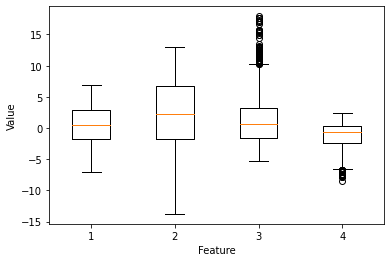

,variance,skewness,kurtosis,entropy,dollar
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [ ]:
import matplotlib.pyplot as plt
plt.boxplot(data)
plt.xlabel('Feature')
plt.ylabel('Value')
plt.show()
df.head()


# **3. 트레이닝셋, 테스트세트, Logistic Regression**

---

트레이닝셋과 테스트세트를 8대2 비율로 나눴습니다. 또한 트레이닝셋에서 트레이닝셋과 평가하는 셋으로 8:2 비율로 나눴습니다. 또한 싱글 layerNN함수를 선언했습니다. 다양한  방법으로 접근할 것이므로, Loss의 추이나, Regularization 함수가 들어가있습니다.

In [ ]:
from sklearn.model_selection import train_test_split
x = data
y = target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=.2, random_state=33)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=.2, random_state=22)
#ramdom_state의 값은 임의적으로 넣었습니다.

In [ ]:
import numpy as np
class SingleLayerNN:
  #learning_rate를 0.01로 했을 때, 정확하게 평가값을 찾았습니다. 4번에 결과
  def __init__(self, learning_rate=.01, l1=0, l2=0):
    self.w = None
    self.b = None
    self.losses = []
    self.val_losses = []
    self.w_history = []
    self.lr = learning_rate
    self.l1 = l1
    self.l2 = l2

  def fwpass(self, x):
    z = np.sum(x*self.w) + self.b
    return z

  def bwpass(self, x, err):
    w_grad = x*err
    b_grad = 1*err
    return w_grad, b_grad

  def activation(self, z):
    a = 1 / (1+np.exp(-z))
    return a

  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    self.w = np.ones(x.shape[1])
    self.b = 0
    self.w_history.append(self.w.copy())
    np.random.seed(0)  
    for i in range(epochs):
      loss = 0
      indexes = np.random.permutation(np.arange(len(x)))
      for i in indexes:
        z = self.fwpass(x[i])
        a = self.activation(z)
        err = -(y[i] - a)
        w_grad, b_grad = self.bwpass(x[i], err)
        w_grad += self.l1*np.sign(self.w)+self.l2*self.w
        self.w -= self.lr*w_grad
        self.b -= b_grad
        self.w_history.append(self.w.copy())
        a = np.clip(a, 1e-10, 1-1e-10)
        loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a))
      self.losses.append(loss/len(y))
      self.update_val_loss(x_val, y_val)

  def predict(self, x):
    z = [self.fwpass(x_i) for x_i in x]
    a = self.activation(np.array(z))
    return a > 0.5

  def score(self, x, y):
    return np.mean(self.predict(x) == y)

  def update_val_loss(self, x_val, y_val):
    if x_val is None:
      return
    val_loss = 0
    for i in range(len(x_val)):
      z = self.fwpass(x_val[i])
      a = self.activation(z)
      a = np.clip(a, 1e-10, 1-1e-10)
      val_loss += -(y_val[i]*np.log(a)+(1-y_val[i])*np.log(1-a))
    self.val_losses.append(val_loss/len(y_val) + self.reg_loss())

  def reg_loss(self):
    return self.l1*np.sum(np.abs(self.w)) + self.l2/2*np.sum(self.w**2)

In [ ]:
#평가 값과 트레이닝값의 학습
layer1 = SingleLayerNN()
layer1.fit(x_train, y_train)
layer1.score(x_val, y_val)

0.9818181818181818

In [ ]:
#트레이닝값과 테스트의 값
layer1 = SingleLayerNN()
layer1.fit(x_train, y_train)
np.mean(layer1.predict(x_test) == y_test)

0.9745454545454545

# **4.Preprocessing and Learning rate**

---
학습에서 얻을 수 있는 거의 최고의 퍼센트를 얻었지만, loss함수의 추이를 보면 학습을 하면서 진폭이 어느정도 있으므로, 이부분을 최소화 하기 위해, preprocessing을 이용해서 진폭을 낮추었습니다. learning rate도 조절해 보았는데, 이때 0.01에서 가장 적합하다고 생각했습니다.

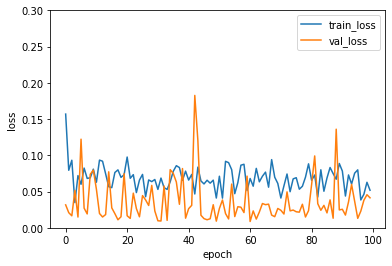

In [ ]:
layer2 = SingleLayerNN()
layer2.fit(x_train, y_train, x_val=x_val, y_val=y_val)
plt.ylim(0, .3)
plt.plot(layer2.losses)
plt.plot(layer2.val_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [ ]:
train_mean = np.mean(x_train, axis=0)
train_std = np.std(x_train, axis=0)
x_train_scaled = (x_train - train_mean) / train_std
x_val_scaled = (x_val - train_mean) / train_std
x_test_scaled = (x_test - train_mean) / train_std

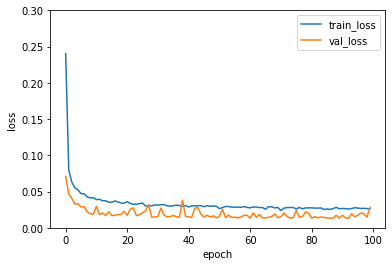

In [ ]:
layer3 = SingleLayerNN()
layer3.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)
plt.ylim(0, .3)
plt.plot(layer3.losses)
plt.plot(layer3.val_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [ ]:
layer2 = SingleLayerNN()
layer2.fit(x_train_scaled, y_train)
layer2.score(x_val_scaled, y_val)

0.9863636363636363

In [ ]:
layer2 = SingleLayerNN(learning_rate=1)
layer2.fit(x_train_scaled, y_train)
layer2.score(x_val_scaled, y_val)

0.9863636363636363

In [ ]:
layer2 = SingleLayerNN(learning_rate=0.01)
layer2.fit(x_train_scaled, y_train)
layer2.score(x_val_scaled, y_val)

0.9954545454545455

In [ ]:
layer2 = SingleLayerNN(learning_rate=0.001)
layer2.fit(x_train_scaled, y_train)
layer2.score(x_val_scaled, y_val)

0.990909090909091

# **5. Regularization and Fitting**

---
정규화와 피팅을 같이 진행하였습니다. ㅣ1 과 ㅣ2 regularization을 각각 진행하면서 가장 잘 맞도록 피팅을 진행했습니다.ㅣ1 regularization에서 0.001, 80 epochs 이며, l2에서는 0.0001, 90 epochs가 평가 값에 잘 맞는다고 생각했습니다.
가장 적절한 모델은 ㅣ1 이라 생각했습니다. 평가 값과 트레이닝 값이 가장 유사해서 선택했습니다.

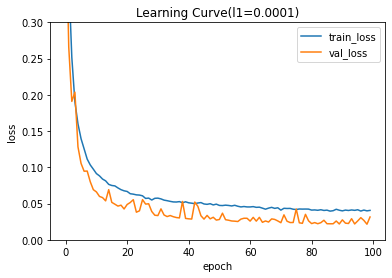

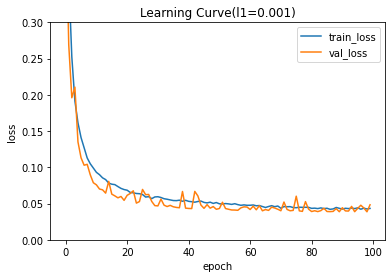

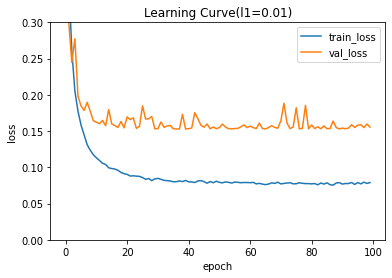

In [ ]:
l1_list = [.0001, .001, .01]

for l1 in l1_list:
  lyr = SingleLayerNN(l1=l1)
  lyr.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)

  plt.plot(lyr.losses)
  plt.plot(lyr.val_losses)
  plt.title('Learning Curve(l1={})'.format(l1))
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train_loss', 'val_loss'])
  plt.ylim(0, .3)
  plt.show()

In [ ]:
layer5 = SingleLayerNN(l1=0.001)
layer5.fit(x_train_scaled, y_train, epochs=80)
layer5.score(x_val_scaled, y_val)

0.9954545454545455

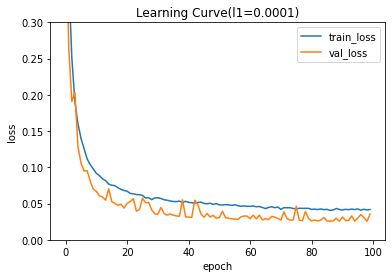

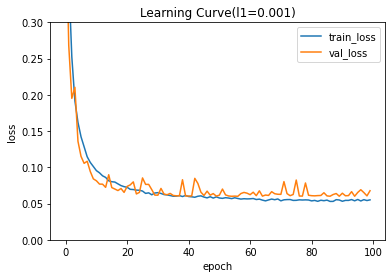

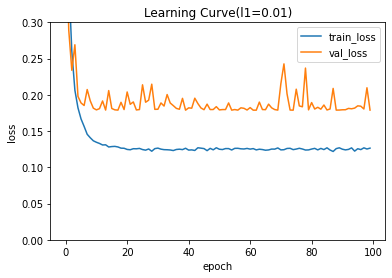

In [ ]:
l2_list = [.0001, .001, .01]

for l2 in l2_list:
  lyr = SingleLayerNN(l2=l2)
  lyr.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)

  plt.plot(lyr.losses)
  plt.plot(lyr.val_losses)
  plt.title('Learning Curve(l1={})'.format(l2))
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train_loss', 'val_loss'])
  plt.ylim(0, .3)
  plt.show()

In [ ]:
layer6 = SingleLayerNN(l2=0.0001)
layer6.fit(x_train_scaled, y_train, epochs=90)
layer6.score(x_val_scaled, y_val)

0.9954545454545455

# **6. Closs Validation**


---
이번에는 Closs validation도 적용해보았습니다. 폴드의 수를 바꿔 가면서, 학습이 어떻게 변하는지 보앗습니다. 20일 때, 가장 괜찮은 성능을 보여주었습니다. sklearn으로 

In [ ]:
validation_scores = []
k = [5,10,20]
for j in k:
  bins = len(x_train_all) // j
  for i in range(j):
      start = i*bins
      end = (i+1)*bins
      val_fold = x_train_all[start:end]
      val_target = y_train_all[start:end]
    
      train_index = list(range(0, start))+list(range(end, len(x_train)))
      train_fold = x_train_all[train_index]
      train_target = y_train_all[train_index]
    
      train_mean = np.mean(train_fold, axis=0)
      train_std = np.std(train_fold, axis=0)
      train_fold_scaled = (train_fold - train_mean) / train_std
      val_fold_scaled = (val_fold - train_mean) / train_std
    
      lyr = SingleLayerNN(l1=0.001)
      lyr.fit(train_fold_scaled, train_target, epochs=80)
      score = lyr.score(val_fold_scaled, val_target)
      validation_scores.append(score)
  print(j)
  print(np.mean(validation_scores))

5
0.9844748858447488
10
0.9838157876363233
20
0.9861856021086888


In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
sgd = SGDClassifier(loss='log' ,penalty='l1', alpha=.001, random_state=33)
pipe = make_pipeline(StandardScaler(), sgd)
scores = cross_validate(pipe, x_train_all, y_train_all, cv=20, return_train_score=True)
print(np.mean(scores['test_score']))

0.9881649831649831


# **결과 분석 및 결론**

---
가장 적절한 모델은 learning rate는 0.01, ㅣ1 regularization에 0.001로 가중치를 주었을 때, epochs는 80 에 preprocessing한 값이 가장 적합한 모델이라고 할 수 있겠습니다. 이 모델을 바탕으로 테스트를 한 결과, 0.9818 변하지 않았습니다. 평가 값에 맞춰 정확도를 올렸지만, 꼭 테스트에서 값이 변하지 않는다는 사실을 알게 됐습니다. 원인은 learning rate에서 local optium에 빠진거 같습니다.

In [ ]:
Last_model = SingleLayerNN(l1=0.001)
Last_model.fit(x_train_scaled, y_train, epochs=80)
Last_model.score(x_val_scaled, y_val)

0.9954545454545455

In [ ]:
Last_model.score(x_test_scaled, y_test)

0.9818181818181818

In [ ]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss='log', random_state=0)

sgd.fit(x_train, y_train)
sgd.score(x_test, y_test)

0.9890909090909091

In [ ]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss='log', penalty='l1', alpha=.001, random_state=33)
sgd.fit(x_train_scaled, y_train)
sgd.score(x_test_scaled, y_test)

0.9927272727272727